In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from file_cache import *


2020-05-25 23:31:10,396 util_log.py[153] INFO Start the program at:amax7, 127.0.1.1, with:Load module


File_cache: Adjust notebook work fold to:/share/felix/pj/brain_seg/


In [3]:
from fastai.vision import *
from fastai.vision.learner import *
from fastai.callbacks.hooks import *

In [4]:

from file_cache import *

img_file_list = glob('/share/data2/body/brain/train/image/**/*.*', recursive=True)

df = pd.DataFrame({'img_file':img_file_list})
df['p_id_path'] = df.img_file.apply(lambda val: os.path.dirname(val))
df['p_id'] = df['p_id_path'].rank(method='max').astype(int)
df.sort_values('p_id')

df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'label'))

df['valid'] = df.p_id%5 ==1

df.valid.value_counts()

2020-05-25 23:31:14,789 utils.py[129] INFO Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-05-25 23:31:14,790 utils.py[141] INFO NumExpr defaulting to 8 threads.


False    602
True     209
Name: valid, dtype: int64

## Datasets

In [5]:
size =224
bs = 8
print('size, bs', size, bs)

size, bs 224 8


In [6]:
codes = range(5)

def get_y_fn(x):
    print(x)
    return x.replace('image', 'label')


src = (SegmentationItemList.from_df(df, path='/', cols='img_file' )
       .split_from_df(col='valid')
       #.label_from_func(get_y_fn, classes=codes)
       .label_from_df(cols='label_path', classes=codes)
      )
       #.label_from_func(cols='label_path', classes=codes))
    
print(len(src.train), len(src.valid))

#get_transforms()
data = (src.transform(None, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

602 209


In [7]:
for a, b in data.dl(DatasetType.Train):
    break
    
a.shape

torch.Size([8, 3, 224, 224])

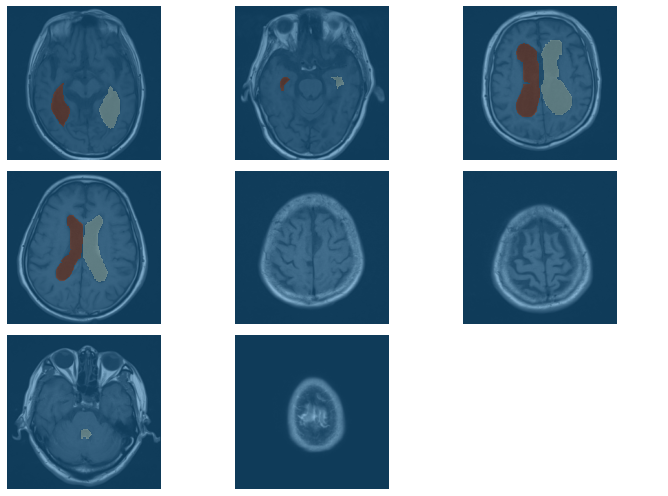

In [8]:
data.show_batch(4, figsize=(10, 7))

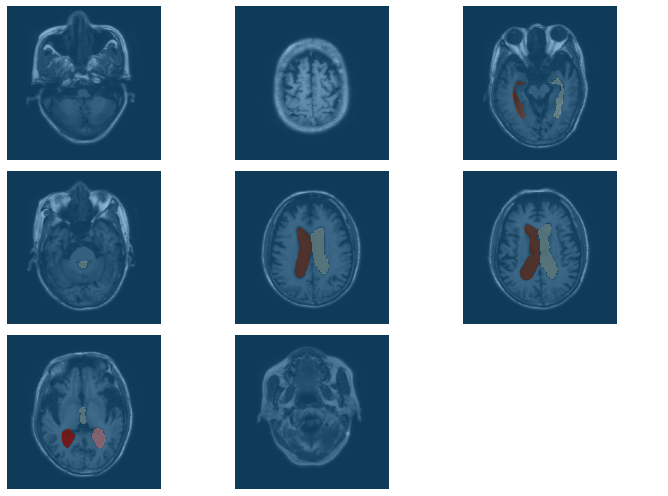

In [9]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [10]:
name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [11]:
wd = 1e-2


In [12]:
print('abc')

abc


In [13]:
#多类别的Dice Metrics

from brain.metrics import * 

from functools import partial
def dice_fn(cls_id):
    fn = partial(dice_multiply, cls_id=cls_id) 
    fn.__name__ = f'dice_{cls_id}'
    return fn
 

metrics_ = [ dice_fn(i) for i in range(5) ] #, accuracy,

import ipdb
#ipdb.set_trace()
from brain.module_unet import *
#model_fn = partial( unet_normal,   img_size = (224,224)) #n_classes=5,
#model_fn()
#models.resnet34()
# for sn, child in enumerate(learn.model.children()):
#     print(sn, '===', child)

In [14]:
#ipdb.set_trace()

model = dynamic_unet( n_classes=5, img_size = (224,224))
# #learn = unet_learner(data, dynamic_unet, metrics=metrics, wd=wd)
# learn = Learner(data, model, metrics=metrics_, wd=wd)

In [15]:
from fastai.vision.learner import cnn_config
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    try:    size = data.train_ds[0][0].size
    except: size = next(iter(data.train_dl))[0].shape[-2:]
#     model = to_device(models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
#           self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
#           bottle=bottle), data.device)
    model = dynamic_unet(arch=models.resnet34, n_classes=5, img_size = (224,224))
    learn = Learner(data, model,metrics=metrics_, )
#     learn.split(ifnone(split_on, meta['split']))
#     if pretrained: learn.freeze()
#     apply_init(model[2], nn.init.kaiming_normal_)
    return learn


learn = unet_learner(data, models.resnet34, metrics=metrics_, wd=wd)

lr = 1e-4

learn.fit(5, slice(lr))

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.064252,0.038597,0.992285,0.586267,0.639262,0.928543,0.890903,00:17
1,0.031595,0.014347,0.997653,0.808275,0.827814,0.926573,0.890903,00:14
2,0.016616,0.012432,0.997820,0.844565,0.853969,0.906847,0.892512,00:14
3,0.013996,0.016295,0.997388,0.870549,0.826717,0.931425,0.884259,00:14
4,0.010387,0.009466,0.998208,0.878626,0.896456,0.914311,0.943306,00:14


In [16]:
#from fastai.vision.learner import cnn_config
def unet_learner2(arch:Callable=models.resnet34, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, 
                  blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    #meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)

    img_size = (224, 224)
#     model = to_device(models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
#           self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
#           bottle=bottle), data.device)
    
    model = to_device(
        models.unet.DynamicUnet(body, n_classes=5, img_size=img_size, blur=blur, blur_final=blur_final,
                                self_attention=self_attention, y_range=y_range, norm_type=norm_type,
                                last_cross=last_cross,
                                bottle=bottle), 'cuda')
    return model
# learn = Learner(data, model, metrics=metrics_)# **learn_kwargs)
# #     learn.split(ifnone(split_on, meta['split']))
# #     if pretrained: learn.freeze()
# #     apply_init(model[2], nn.init.kaiming_normal_)
# return learn

model = unet_learner2()

#learn = unet_learner(data, unet_learner, metrics=metrics_)
learn = Learner(data, model,metrics=metrics_, )
lr = 1e-4

learn.fit(5, slice(lr))

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.050685,0.014498,0.997755,0.863628,0.868703,0.928543,0.890903,00:14
1,0.018515,0.009267,0.998260,0.916078,0.842119,0.913109,0.894161,00:14
2,0.010506,0.007657,0.998489,0.927549,0.910056,0.945445,0.962045,00:14
3,0.007537,0.006427,0.998675,0.936732,0.929512,0.964873,0.955256,00:14
4,0.006353,0.006630,0.998687,0.935566,0.928846,0.943400,0.957094,00:14


In [33]:

# def dynamic_unet2(arch: Callable=models.resnet34, pretrained: bool = True, blur_final: bool = True,
#                  norm_type: Optional[NormType] = NormType, split_on: Optional[SplitFuncOrIdxList] = None,
#                  blur: bool = False,
#                  self_attention: bool = False, y_range: Optional[Tuple[float, float]] = None, last_cross: bool = True,
#                  bottle: bool = False, cut: Union[int, Callable] = None,
#                  n_classes=2, img_size=(224, 224), in_channels=1,
#                  **learn_kwargs: Any) -> Learner:
#     body = create_body(arch, pretrained, cut)
#     model = to_device(
#         models.unet.DynamicUnet(body, n_classes=5, img_size=(224,224), blur=blur, blur_final=blur_final,
#                                 self_attention=self_attention, y_range=y_range, norm_type=norm_type,
#                                 last_cross=last_cross,
#                                 bottle=bottle), 'cuda')
#     return model

# #     body = create_body(arch, pretrained, cut)
# #     model = to_device(
# #         models.unet.DynamicUnet(body, n_classes=n_classes, img_size=img_size, blur=blur, blur_final=blur_final,
# #                                 self_attention=self_attention, y_range=y_range, norm_type=norm_type,
# #                                 last_cross=last_cross,
# #                                 bottle=bottle), 'cuda')
# #     return model

# model = dynamic_unet2(arch=models.resnet34)
#model = unet_learner()
learn = Learner(data, unet_normal(), metrics=metrics_, )

#learn = unet_learner(data, models.resnet34, metrics=metrics_, wd=wd)

lr = 1e-3

learn.fit(50, slice(lr))



epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,1.210643,0.617987,0.992889,0.552285,0.546874,0.923821,0.890903,00:17
1,0.586044,0.323592,0.994915,0.453604,0.568106,0.928543,0.890903,00:17
2,0.244985,0.385113,0.979837,0.390211,0.433586,0.928543,0.890903,00:17
3,0.107987,0.051477,0.996622,0.667550,0.709381,0.928543,0.890903,00:17
4,0.061840,1.324298,0.796645,0.031565,0.182943,0.928543,0.890903,00:17
5,0.041956,0.035316,0.994753,0.746878,0.721532,0.928543,0.890903,00:17
6,0.029032,0.038648,0.994268,0.533767,0.793537,0.928543,0.890903,00:17
7,0.023976,0.039531,0.994598,0.506282,0.675115,0.928543,0.890903,00:17
8,0.019522,0.056687,0.989404,0.540008,0.638600,0.928543,0.890903,00:17
9,0.018927,1.917861,0.725303,0.043995,0.073747,0.928543,0.890903,00:17


In [27]:
lr = 1e-3

learn.fit_one_cycle(50, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.032424,0.023596,0.998670,0.871512,0.842797,0.938983,0.878907,00:17
1,0.026245,0.026276,0.998682,0.846871,0.840583,0.866551,0.935002,00:17
2,0.023137,0.024164,0.998722,0.877432,0.843211,0.921170,0.962690,00:17
3,0.020238,0.033330,0.998701,0.841590,0.893263,0.951973,0.961501,00:17
4,0.018891,0.027317,0.998636,0.848993,0.910250,0.879803,0.962091,00:17
5,0.017729,0.016226,0.998545,0.866450,0.863972,0.895442,0.931172,00:17
6,0.022756,0.029451,0.998451,0.861687,0.810051,0.931781,0.894330,00:17
7,0.018780,0.015718,0.998268,0.820671,0.702036,0.877010,0.942949,00:17
8,0.020756,0.054408,0.998252,0.806181,0.894589,0.701782,0.526604,00:17
9,0.020395,0.014350,0.998540,0.924024,0.898093,0.851696,0.915742,00:17


In [28]:
learn.model

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (residual_input_conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (residual_batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (residual_input_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (residual_batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): 

In [32]:
model = dynamic_unet(arch=models.resnet34, n_classes=5, img_size = (224,224))
learn = Learner(data, model,metrics=metrics_, )

#learn = unet_learner(data, models.resnet34, metrics=metrics_, wd=wd)

lr = 1e-4

learn.fit(5, slice(lr))

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.107259,0.041501,0.994678,0.554596,0.502820,0.928543,0.890903,01:10
1,0.049837,0.028219,0.995442,0.683879,0.787713,0.928543,0.890903,01:11
2,0.031170,0.014461,0.997703,0.839610,0.741323,0.928543,0.890903,01:12
3,0.018058,0.011431,0.998046,0.754278,0.808887,0.892306,0.890903,01:12
4,0.013280,0.010904,0.998035,0.871686,0.839432,0.914724,0.890903,01:12


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/aladdin1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/aladdin1/anaconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/aladdin1/anaconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/home/aladdin1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/aladdin1/anaconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/aladdin1/anaconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/aladdin1/anaconda3/lib/python3.7/multipro

In [15]:
os.path.abspath('./output/model')

'/share/felix/pj/brain_seg/output/model'

In [22]:

learn.model_dir=os.path.abspath('./output/model')
os.makedirs(learn.model_dir, exist_ok=True)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


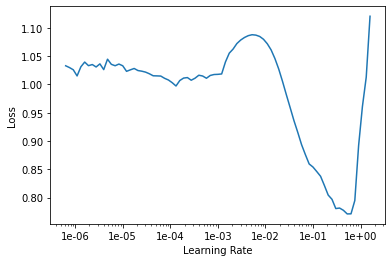

In [23]:
learn.recorder.plot()

In [18]:
lr = 1e-4

learn.fit(5, slice(lr))

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.101391,0.031062,0.995145,0.667206,0.653896,0.928543,0.890903,01:06
1,0.042806,0.017428,0.997228,0.781809,0.797102,0.928543,0.890903,01:05
2,0.025368,0.023985,0.995991,0.787715,0.776365,0.928543,0.890903,01:05
3,0.018917,0.028461,0.994469,0.522919,0.575411,0.691862,0.890903,01:06
4,0.016644,0.014424,0.997523,0.670234,0.808209,0.857648,0.890903,01:06


In [18]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.677941,0.138525,0.989899,0.456658,0.020030,0.928543,0.008947,00:13
1,0.181068,0.031367,0.994071,0.774148,0.236783,0.928543,0.445917,00:13
2,0.056620,0.017546,0.997126,0.823155,0.835816,0.926150,0.890903,00:13
3,0.024056,0.010952,0.998042,0.843669,0.861765,0.906503,0.897325,00:13
4,0.013958,0.010376,0.998113,0.898321,0.880896,0.941537,0.911558,00:15


In [19]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.008133,0.009054,0.998272,0.893256,0.893922,0.940705,0.939579,00:14
1,0.007692,0.009093,0.998201,0.824754,0.856663,0.939227,0.949726,00:13
2,0.008122,0.009917,0.998131,0.909248,0.893063,0.950046,0.952405,00:13
3,0.008198,0.007862,0.998488,0.919245,0.911258,0.952213,0.958844,00:13
4,0.006357,0.007123,0.998586,0.925138,0.907763,0.954668,0.953996,00:13


In [20]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.004732,0.007082,0.998612,0.929776,0.914569,0.952717,0.958974,00:13
1,0.004485,0.007162,0.998591,0.928221,0.918686,0.952330,0.959283,00:13
2,0.004263,0.007063,0.998655,0.930663,0.923215,0.962657,0.962846,00:13
3,0.004154,0.007414,0.998654,0.930143,0.920172,0.962028,0.957052,00:13
4,0.004708,0.007645,0.998518,0.911722,0.922798,0.949589,0.945514,00:13
5,0.004822,0.007336,0.998706,0.937998,0.914496,0.963110,0.960703,00:13
6,0.006813,0.009476,0.998461,0.928641,0.890621,0.947667,0.941609,00:14
7,0.004944,0.006329,0.998742,0.938510,0.924690,0.957952,0.946992,00:13
8,0.003862,0.006800,0.998718,0.935182,0.930016,0.939165,0.957413,00:13
9,0.003389,0.006684,0.998791,0.937917,0.928837,0.963635,0.965880,00:13


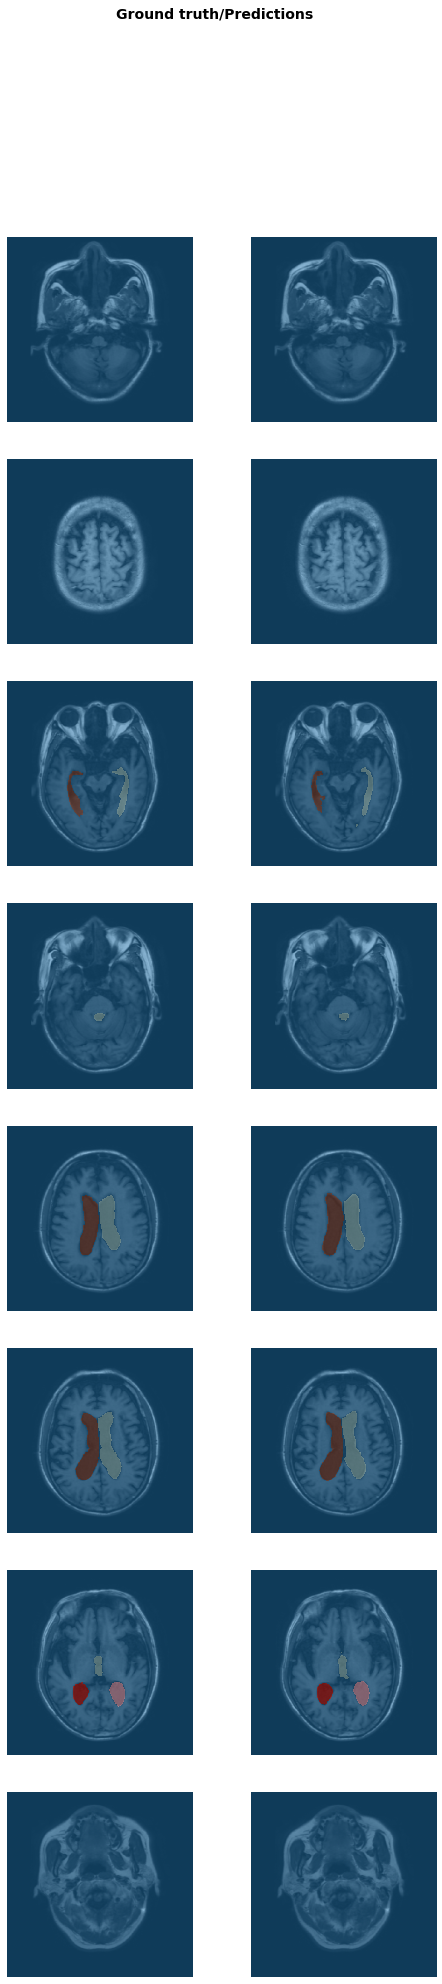

In [21]:
learn.show_results(DatasetType.Valid, rows=40)
